Directory cleared. Current contents: ['.config', 'sample_data']


Saving theft_protection.zip to theft_protection.zip
Saving utils.py to utils.py
Saving lstm.py to lstm.py
Contents of theft_protection.zip:
['single_thread/.DS_Store', 'single_thread/version description.rtf', 'single_thread/version_1.1/', 'single_thread/version_1.1/.DS_Store', 'single_thread/version_1.1/normal/', 'single_thread/version_1.1/normal/log1', 'single_thread/version_1.1/normal/log2', 'single_thread/version_1.1/normal/log3', 'single_thread/version_1.1/normal/log4', 'single_thread/version_1.1/normal/log5', 'single_thread/version_1.1/normal/log6', 'single_thread/version_1.1/normal/trace1', 'single_thread/version_1.1/normal/trace2', 'single_thread/version_1.1/normal/trace3', 'single_thread/version_1.1/normal/trace4', 'single_thread/version_1.1/normal/trace5', 'single_thread/version_1.1/normal/trace6', 'single_thread/version_1.1/semantic_error/', 'single_thread/version_1.1/semantic_error/log1', 'single_thread/version_1.1/semantic_error/log2', 'single_thread/version_1.1/semantic_er

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 1.5630 - mae: 0.3544 - val_loss: 0.5963 - val_mae: 0.0927
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 0.4750 - mae: 0.1467 - val_loss: 0.1881 - val_mae: 0.0806
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.1626 - mae: 0.1352 - val_loss: 0.0730 - val_mae: 0.0813
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - loss: 0.0746 - mae: 0.1318 - val_loss: 0.0420 - val_mae: 0.0834
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.0484 - mae: 0.1253 - val_loss: 0.0322 - val_mae: 0.0823
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0379 - mae: 0.1189 - val_loss: 0.0282 - val_mae: 0.0912
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.0372 - mae: 0.1279 - val_loss: 0.0277 - val_mae: 0.0857
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0325 - mae: 0.1165 - val_loss: 0.0248 - val_mae: 0.0865
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss

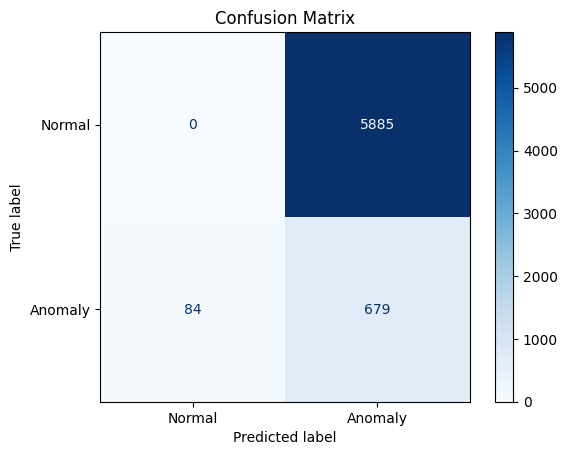

In [ ]:
import os
import numpy as np
import pandas as pd
import json
import shutil
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import zipfile
from google.colab import files
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping






def test_single(file_path, model, scaler, sequence_length, threshold):
    anomalies = []

    # Load test data
    if file_path.find('.npy') != -1:
        sample_data = np.load(file_path)
    else:
        sample_data = read_traces(file_path)

    # Scale test data
    sample_data_scaled = scaler.transform(sample_data)

    # Prepare sequences for the LSTM model
    X_test, y_test = [], []
    for i in range(len(sample_data_scaled) - sequence_length):
        X_test.append(sample_data_scaled[i:i + sequence_length])
        y_test.append(sample_data_scaled[i + sequence_length])
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate reconstruction errors
    errors = np.mean(np.abs(predictions - y_test), axis=1)

    # Determine anomalies based on the threshold
    for i in range(len(errors)):
        if errors[i] > threshold:
            # Anomaly detected
            start_idx = i
            end_idx = i + sequence_length
            anomalies.append([(start_idx, end_idx), (sample_data[start_idx][1], sample_data[end_idx][1]), os.path.basename(file_path)])

    return anomalies



# Clean the directory
current_dir = './'
for item in os.listdir(current_dir):
    if item not in ['.config', 'sample_data']:
        item_path = os.path.join(current_dir, item)
        if os.path.isfile(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

print("Directory cleared. Current contents:", os.listdir(current_dir))

# Upload files
uploaded = files.upload()

# Extract and organize data
zip_file_path = './theft_protection.zip'
extraction_path = './theft_protection'
base_dir = './trace_data'

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print("Contents of theft_protection.zip:")
        print(zip_ref.namelist())
        zip_ref.extractall(extraction_path)
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    if os.path.exists('./theft_protection'):
        shutil.move('./theft_protection', f'{base_dir}/theft_protection')
else:
    print("Zip file not found.")

from utils import get_paths, read_traces, read_json, mapint2var, is_consistent
from lstm import test_single, merge_detections, get_correct_detections

# Configuration
CODE = 'theft_protection'
BEHAVIOUR_FAULTY = 'faulty_data'
BEHAVIOUR_NORMAL = 'normal'
THREAD = 'single'
VER = 3

normalbase_path = f'{base_dir}/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_NORMAL}'
faultybase_path = f'{base_dir}/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_FAULTY}'

print("Normal base path:", normalbase_path)
print("Faulty base path:", faultybase_path)

train_base_path = os.path.join(normalbase_path, 'train_data')
train_data_path = [os.path.join(train_base_path, x) for x in os.listdir(train_base_path)]
train_varlist_path = [os.path.join(normalbase_path, x) for x in os.listdir(normalbase_path) if 'varlist' in x]

paths_log, paths_traces, varlist_path, paths_label = get_paths(faultybase_path)

train_data_path = [x for x in train_data_path if '.DS_Store' not in x]
train_varlist_path = [x for x in train_varlist_path if '.DS_Store' not in x]
paths_log = [x for x in paths_log if '.DS_Store' not in x]
paths_traces = [x for x in paths_traces if '.DS_Store' not in x]
varlist_path = [x for x in varlist_path if '.DS_Store' not in x]
paths_label = [x for x in paths_label if '.DS_Store' not in x]

paths_log.sort()
paths_traces.sort()
varlist_path.sort()
paths_label.sort()

test_data_path = paths_traces
test_label_path = paths_label
print("Test data path:", test_data_path)
print("Test label path:", test_label_path)

# Check consistency
if VER == 3:
    check_con, _ = is_consistent([train_varlist_path[0]] + varlist_path)
    if check_con:
        to_number = read_json(varlist_path[0])
        from_number = mapint2var(to_number)
    else:
        to_number = read_json(train_varlist_path[0])
        from_number = mapint2var(to_number)

sorted_keys = list(from_number.keys())
sorted_keys.sort()
var_list = [from_number[key] for key in sorted_keys]

# Load training data
def load_data(file_paths):
    data = []
    for file in file_paths:
        traces = read_traces(file)
        if isinstance(traces, list):
            data.extend(traces)
    return np.array(data)

train_data = load_data(train_data_path)
scaler = MinMaxScaler() #Min Max scaler
#scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Prepare LSTM training data
sequence_length = 60
X_train, y_train = [], []
for i in range(len(train_data_scaled) - sequence_length):
    X_train.append(train_data_scaled[i:i + sequence_length])
    y_train.append(train_data_scaled[i + sequence_length])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(sequence_length, train_data_scaled.shape[1]), kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    LSTM(64, activation='relu', return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(X_train.shape[2], activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

# Test data
test_data = load_data(test_data_path)
test_data_scaled = scaler.transform(test_data)
X_test, y_test = [], []
for i in range(len(test_data_scaled) - sequence_length):
    X_test.append(test_data_scaled[i:i + sequence_length])
    y_test.append(test_data_scaled[i + sequence_length])
X_test, y_test = np.array(X_test), np.array(y_test)

# Predictions and errors
predictions = model.predict(X_test)
errors = np.mean(np.abs(predictions - y_test), axis=1)
train_predictions = model.predict(X_train)
train_errors = np.mean(np.abs(train_predictions - y_train), axis=1)

# Finding anomalies by using threshold
threshold = np.percentile(train_errors, 95)
anomalies = errors > threshold


## checking the detections against the ground truth
DIFF_VAL = 0
all_detections = []         # To store detections for each file
y_pred_all = []             # To store the predicted labels
y_true_all = []             # To store the ground truth labels
all_tp = []                 # To store all true positives
all_fp = []                 # To store all false positives
all_fn = []                 # To store all false negatives
all_gt = []                 # To store the ground truth


for test_data, test_label in zip(test_data_path, test_label_path):
    print(f"Processing file: {test_data}")
    detection = test_single(test_data, model, scaler, sequence_length, threshold)
    all_detections.append((test_data, detection, test_label))

    merged_detection, grouped_detection = merge_detections(detection, DIFF_VAL)
    detection = merged_detection

    ground_truth_raw = read_traces(test_label)
    ground_truth = ground_truth_raw['labels']
    label_trace_name = list(ground_truth.keys())[0]
    ground_truth = ground_truth[label_trace_name]

    print("Ground Truth:", ground_truth)

    correct_pred, rest_pred, y_pred, y_true, false_neg = get_correct_detections(detection, ground_truth)
    y_pred_all.extend(y_pred)
    y_true_all.extend(y_true)
    all_tp.append((test_data, correct_pred, test_label))
    all_fp.append((test_data, rest_pred, test_label))
    all_fn.append((test_data, false_neg, test_label))
    all_gt.append((test_data, ground_truth, test_label))

y_pred_all = np.array(y_pred_all)
y_true_all = np.array(y_true_all)


# Calculate evaluation metrics
precision = precision_score(y_true_all, y_pred_all)
recall = recall_score(y_true_all, y_pred_all)
f1 = f1_score(y_true_all, y_pred_all)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



conf_matrix = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
